In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import os

import matplotlib.pyplot as plt

2024-01-30 09:37:11.255938: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 09:37:11.256036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 09:37:11.378692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path = '/kaggle/input/wildfirev1/train'
valid_path = '/kaggle/input/wildfirev1/valid'
test_path = '/kaggle/input/wildfirev1/test'

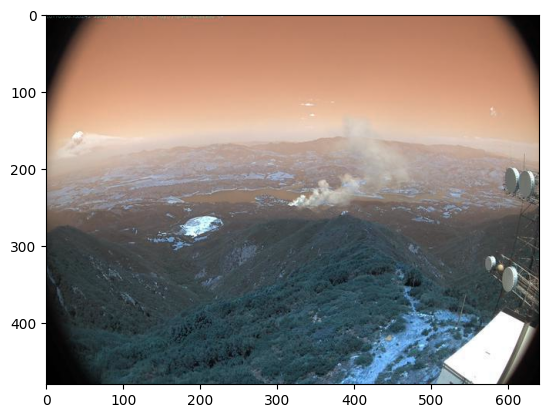

In [3]:
for i in os.listdir(train_path)[2:]:
    img = cv2.imread(os.path.join(train_path, i), cv2.IMREAD_COLOR)
    plt.imshow(img)
    break